In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from os import listdir
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.applications import imagenet_utils
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from os import listdir

Using TensorFlow backend.


In [2]:
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    return text

In [3]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return (dataset)

In [4]:
# load training dataset (6K)
train_text_filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(train_text_filename)
print('Train-Dataset: %d' % len(train))

Train-Dataset: 6000


In [5]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [6]:
'''
model_weights_list=listdir('VGG16_models')
print('total number of model weights: ',len(model_weights_list))
dir ='VGG16_models'
for mod in listdir(dir):
    dest = dir+'/'+mod[-6:]
    src  = dir+'/'+mod
    print(src,'  -  ',dest)
    os.rename(src,dest)
'''

"\nmodel_weights_list=listdir('VGG16_models')\nprint('total number of model weights: ',len(model_weights_list))\ndir ='VGG16_models'\nfor mod in listdir(dir):\n    dest = dir+'/'+mod[-6:]\n    src  = dir+'/'+mod\n    print(src,'  -  ',dest)\n    os.rename(src,dest)\n"

In [7]:
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

Dataset: 1000


In [8]:
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [9]:
def load_photo_features(filename, dataset):
    # load all features
    features = load(open(filename, 'rb'))
    # filter features
    return features

In [10]:
test_features = load_photo_features('encoded_test_images.pkl', test)
print('Photos: test=%d' % len(test_features))

Photos: test=1000


In [11]:
wordtoix= load(open('w2i.pkl','rb'))

In [12]:
ixtoword= load(open('i2w.pkl','rb'))

In [13]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [14]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(34):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=34)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


In [22]:
# evaluate the skill of the model
import sys
def evaluate_mod(x, model, descriptions, photos, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    a=0
    for key, desc_list in descriptions.items():
        # generate description---------------------------------------------------------
        a=a+1
        sys.stdout.write('\r'+str(a))
        sys.stdout.flush()
        re_key=key+'.jpg'
        image = encoding_test[re_key].reshape((1,4096))
        yhat=greedySearch(image)
                
        # store actual and predicted------------------------------------------------------------
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    a = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    c = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    d = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('BLEU -1: ',a)
    print('BLEU -2: ',b)
    print('BLEU -3: ',c)
    print('BLEU -4: ',d)
    

    return ([a,b,c,d])

a=0
li=list()
direc='VGG16_models'
# sort the files
all_weights=sorted(listdir(direc))
print(len(all_weights))

for modwei in all_weights[:-20]:
    a=a+1
    print('model name = ',modwei,': ',a,'/',len(listdir(direc)))
    modwei='VGG16_models/'+modwei
    model=load_model(modwei)
    start = time()
    li.append(evaluate_mod(str(a),model, test_descriptions, test_features, max_length=34))
    print('\nTime taken for ',a,'th  model ', time()-start)

25
model name =  199.h5 :  1 / 25
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
1000BLEU -1:  0.41165593669249867
BLEU -2:  0.2143678904363477
BLEU -3:  0.129838203540994
BLEU -4:  0.050454075379330623

Time taken for  1 th  model  90.88747668266296
model name =  403.h5 :  2 / 25
1000BLEU -1:  0.393349631938605
BLEU -2:  0.21496328787735008
BLEU -3:  0.14564050760597394
BLEU -4:  0.062784662720975

Time taken for  2 th  model  96.66139054298401
model name =  408.h5 :  3 / 25
1000BLEU -1:  0.3927425440602189
BLEU -2:  0.2156248899861395
BLEU -3:  0.1449201475963015
BLEU -4:  0.06200655110162312

Time taken for  3 th  model  101.30207443237305
model name =  411.h5 :  4 / 25
1000BLEU -1:  0.3928057664693367
BLEU -2:  0.21579744945231102
BLEU -3:  0.146327834628913
BLEU -4:  0.06289237491084212

Time tak

In [23]:
# evaluate the skill of the model
import sys
def evaluate_mod(x, model, descriptions, photos, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    a=0
    for key, desc_list in descriptions.items():
        # generate description---------------------------------------------------------
        a=a+1
        sys.stdout.write('\r'+str(a))
        sys.stdout.flush()
        re_key=key+'.jpg'
        image = encoding_test[re_key].reshape((1,4096))
        yhat=greedySearch(image)
                
        # store actual and predicted------------------------------------------------------------
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    a = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    c = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    d = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('BLEU -1: ',a)
    print('BLEU -2: ',b)
    print('BLEU -3: ',c)
    print('BLEU -4: ',d)
    

    return ([a,b,c,d])

a=0
li=list()
direc='VGG16_models'
# sort the files
all_weights=sorted(listdir(direc))
print(len(all_weights))

for modwei in all_weights[5:-10]:
    a=a+1
    print('model name = ',modwei,': ',a,'/',len(listdir(direc)))
    modwei='VGG16_models/'+modwei
    model=load_model(modwei)
    start = time()
    li.append(evaluate_mod(str(a),model, test_descriptions, test_features, max_length=34))
    print('\nTime taken for ',a,'th  model ', time()-start)

25
model name =  417.h5 :  1 / 25
1000BLEU -1:  0.3986268694117269
BLEU -2:  0.21752380715597436
BLEU -3:  0.1465890211062383
BLEU -4:  0.06388277433140901

Time taken for  1 th  model  100.86240863800049
model name =  424.h5 :  2 / 25
1000BLEU -1:  0.3968702162407838
BLEU -2:  0.21933625582815405
BLEU -3:  0.1498434385712965
BLEU -4:  0.06556295385256908

Time taken for  2 th  model  100.5989396572113
model name =  429.h5 :  3 / 25
1000BLEU -1:  0.3985142891618183
BLEU -2:  0.21718355482366294
BLEU -3:  0.14671802070144108
BLEU -4:  0.06299208808593679

Time taken for  3 th  model  100.41246438026428
model name =  437.h5 :  4 / 25
1000BLEU -1:  0.39692709115004415
BLEU -2:  0.2177289819013013
BLEU -3:  0.14757505019285233
BLEU -4:  0.06321944023152055

Time taken for  4 th  model  102.38078880310059
model name =  440.h5 :  5 / 25
1000BLEU -1:  0.3961441981640572
BLEU -2:  0.21440758939745658
BLEU -3:  0.14473660627134247
BLEU -4:  0.062495397115417475

Time taken for  5 th  model  105

In [24]:
with open('max_score_vgg16.pkl','wb') as pik:
    dump(li,pik)

In [25]:
scores = load(open('max_score_vgg16.pkl','rb'))
y=scores

In [26]:

y1=list()
y2=list()
y3=list()
y4=list()
for i in y:
    y1.append(round(i[0],7)) 
    y2.append(round(i[1],7))
    y3.append(round(i[2],7))
    y4.append(round(i[3],7))

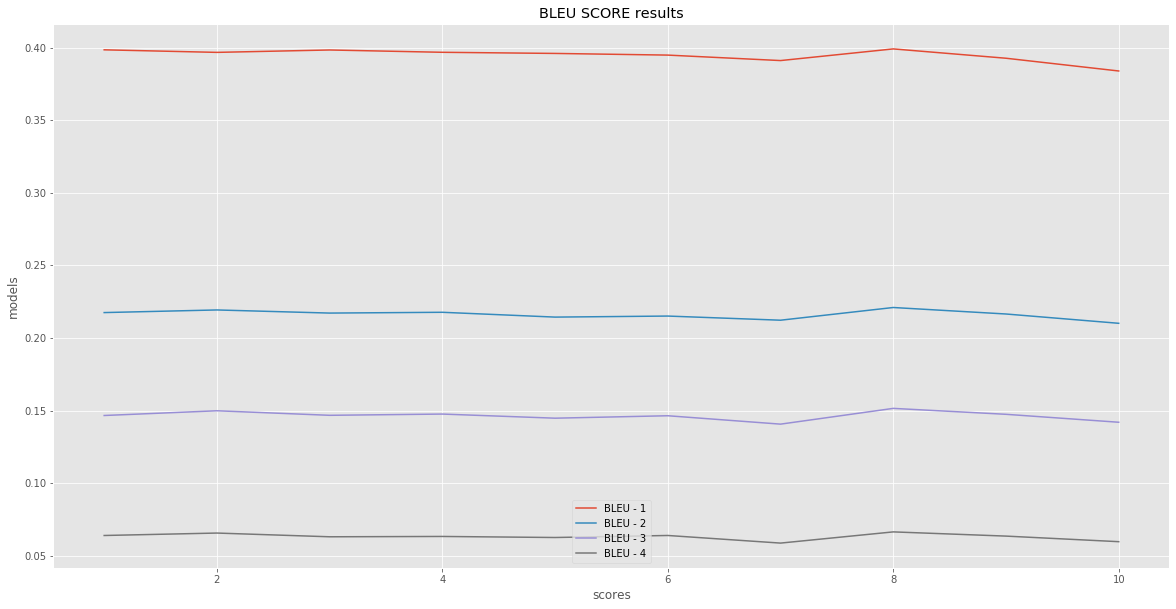

In [29]:
x=list(range(1,11))
plt.style.use("ggplot")
fig= plt.figure(figsize=(20,10))
plt.plot(x,y1,label='BLEU - 1')
plt.plot(x,y2,label='BLEU - 2')
plt.plot(x,y3,label='BLEU - 3')
plt.plot(x,y4,label='BLEU - 4')
plt.title('BLEU SCORE results')
plt.xlabel('scores')
plt.ylabel('models')
plt.legend()
plt.show()

In [68]:
# evaluate the skill of the model
import sys
def evaluate_mod(x, model, descriptions, photos, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    a=0
    for key, desc_list in descriptions.items():
        # generate description---------------------------------------------------------
        a=a+1
        sys.stdout.write('\r'+str(a))
        sys.stdout.flush()
        re_key=key+'.jpg'
        image = encoding_test[re_key].reshape((1,4096))
        yhat=greedySearch(image)
                
        # store actual and predicted------------------------------------------------------------
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    a = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    c = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    d = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('BLEU -1: ',a)
    print('BLEU -2: ',b)
    print('BLEU -3: ',c)
    print('BLEU -4: ',d)
    

    return ([a,b,c,d])

a=0
li=list()
direc='vgg16_models'
print
for modwei in listdir(direc):
    a=a+1
    print('model name = ',modwei,': ',a,'/',len(listdir(direc)))
    modwei='vgg16_models/'+modwei
    model=load_model(modwei)
    start = time()
    li.append(evaluate_mod(str(a),model, test_descriptions, test_features, max_length=34))
    print('\nTime taken for ',a,'th  model ', time()-start)

model name =  447.h5 :  1 / 35
1000BLEU -1:  0.38631588585121435
BLEU -2:  0.21813058378346606
BLEU -3:  0.14980248408812954
BLEU -4:  0.06517355825535046

Time taken for  1 th  model  101.07127594947815
model name =  552.h5 :  2 / 35
1000BLEU -1:  0.3984993072891696
BLEU -2:  0.2216439503924161
BLEU -3:  0.1498223557742688
BLEU -4:  0.0650332920765486

Time taken for  2 th  model  102.98303627967834
model name =  772.h5 :  3 / 35
1000BLEU -1:  0.39467543025744484
BLEU -2:  0.2194630529859891
BLEU -3:  0.14504952021772913
BLEU -4:  0.061010968365284565

Time taken for  3 th  model  103.68109202384949
model name =  454.h5 :  4 / 35
1000BLEU -1:  0.3890825744435903
BLEU -2:  0.22124682456485922
BLEU -3:  0.1522006895295568
BLEU -4:  0.06707166877403954

Time taken for  4 th  model  100.02858924865723
model name =  503.h5 :  5 / 35
1000BLEU -1:  0.3989916711068241
BLEU -2:  0.22364343462610486
BLEU -3:  0.15138425005757428
BLEU -4:  0.06149097845024109

Time taken for  5 th  model  105.51

KeyboardInterrupt: 

In [47]:
with open('max_score_vgg16.pkl','wb') as pik:
    dump(li,pik)

In [48]:
scores = load(open('max_score_vgg16.pkl','rb'))
y=scores

In [ ]:

y1=list()
y2=list()
y3=list()
y4=list()
for i in y:
    y1.append(round(i[0],7)) 
    y2.append(round(i[1],7))
    y3.append(round(i[2],7))
    y4.append(round(i[3],7))

In [ ]:
x=list(range(1,11))
plt.style.use("ggplot")
fig= plt.figure(figsize=(30,40))
plt.plot(x,y1,label='BLEU - 1')
plt.plot(x,y2,label='BLEU - 2')
plt.plot(x,y3,label='BLEU - 3')
plt.plot(x,y4,label='BLEU - 4')
plt.title('BLEU SCORE results')
plt.xlabel('scores')
plt.ylabel('models')
plt.legend()
plt.show()

In [ ]:
'''# evaluate the skill of the model
import sys
def evaluate_mod(x, model, descriptions, photos, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    a=0
    for key, desc_list in descriptions.items():
        # generate description---------------------------------------------------------
        a=a+1
        sys.stdout.write('\r'+str(a))
        sys.stdout.flush()
        re_key=key+'.jpg'
        image = encoding_test[re_key].reshape((1,2048))
        yhat=greedySearch(image)
        
        
        # store actual and predicted------------------------------------------------------------
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    a = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    c = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    d = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('BLEU -1: ',a)
    print('BLEU -2: ',b)
    print('BLEU -3: ',c)
    print('BLEU -4: ',d)
    

    return ([a,b,c,d])

a=0
li=list()
direc='models/models/check'
for modwei in listdir(direc):
    a=a+1
    print('model ',a,'/10:')
    modwei='models/models/'+modwei
    model=load_model(modwei)
    start = time()
    li.append(evaluate_mod(str(a),model, test_descriptions, test_features, max_length=34))
    print('\nTime taken for ',a,'th  model = ', time()-start)
    '''

In [ ]:
#with open('check_score.pkl','wb') as pik:
#    dump(li,pik)

In [ ]:
#scores = load(open('check_score.pkl','rb'))
#y=scores

In [ ]:
'''y1=list()
y2=list()
y3=list()
y4=list()
for i in y:
    y1.append(round(i[0],7)) 
    y2.append(round(i[1],7))
    y3.append(round(i[2],7))
    y4.append(round(i[3],7))
'''

In [ ]:
'''
x=list(range(1,11))
plt.style.use("ggplot")
fig= plt.figure(figsize=(30,40))
plt.plot(x,y1,label='BLEU - 1')
plt.plot(x,y2,label='BLEU - 2')
plt.plot(x,y3,label='BLEU - 3')
plt.plot(x,y4,label='BLEU - 4')
plt.title('BLEU SCORE results')
plt.xlabel('scores')
plt.ylabel('models')
plt.legend()
plt.show()
'''